### Learning reaction types using different ML methods (K-Means, LR) and more local difference fingerprints (AP3, MG2, TT)

Goal: find the best/simplest/most appropriate ML model for our FPs

In [1]:
import _pickle as cPickle
import gzip
from collections import defaultdict
import random
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import utilsFunctions
from pylab import rcParams

Choose some larger text size in the plots

In [2]:
rcParams.update({'font.size': 14})

In [3]:
dataDir = "../data/"

with open(dataDir+"reactionTypes_training_test_set_patent_data.pkl",'rb') as f:
    reaction_types = cPickle.load(f)
with open(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl",'rb') as f:
    names_rTypes = cPickle.load(f)

# reaction_types = cPickle.load(file(dataDir+"reactionTypes_training_test_set_patent_data.pkl"))
# names_rTypes = cPickle.load(file(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl"))

Load the different FPs (AP3, MG2, TT)

In [4]:
infile = gzip.open(dataDir+"transformationFPs_test_set_patent_data.pkl.gz", 'rb')

lineNo=0
fps=[]
idx=0
while 1:
    lineNo+=1
    try:
        lbl,cls,fp_AP3,fp_MG2,fp_TT = cPickle.load(infile)        
    except EOFError:
        break
    fps.append([idx,lbl,cls,fp_AP3,fp_MG2,fp_TT])
    idx+=1
    if not lineNo%10000:
        print("Done "+str(lineNo))

Done 10000
Done 20000
Done 30000
Done 40000
Done 50000


In [5]:
print(idx)

50000


Split the FPs in training (20 %) and test data (80 %) per recation type (200, 800)

In [5]:
random.seed(0xd00f)
indices=list(range(len(fps)))
random.shuffle(indices)

nActive=200
fpsz=2048 # the FPs bit size for converting the FPs to a numpy array
#fpsz=4096
trainFps_fp_AP3=defaultdict(list)
trainFps_fp_MG2=defaultdict(list)
trainFps_fp_TT=defaultdict(list)
trainActs=[]
testFps_fp_AP3=defaultdict(list)
testFps_fp_MG2=defaultdict(list)
testFps_fp_TT=defaultdict(list)
testActs=[]

print('building fp collection')

rtypes=sorted(list(reaction_types))
for i,klass in enumerate(rtypes):
    actIds = [x for x in indices if fps[x][2]==klass]
    for x in actIds[:nActive]:
        trainFps_fp_AP3[klass] += [utilsFunctions.fpToNP(fps[x][3],fpsz)]
        trainFps_fp_MG2[klass] += [utilsFunctions.fpToNP(fps[x][4],fpsz)]
        trainFps_fp_TT[klass] += [utilsFunctions.fpToNP(fps[x][5],fpsz)]
    trainActs += [i]*nActive
    nTest=len(actIds)-nActive
    for x in actIds[nActive:]:
        testFps_fp_AP3[klass] += [utilsFunctions.fpToNP(fps[x][3],fpsz)]
        testFps_fp_MG2[klass] += [utilsFunctions.fpToNP(fps[x][4],fpsz)]
        testFps_fp_TT[klass] += [utilsFunctions.fpToNP(fps[x][5],fpsz)]
    testActs += [i]*nTest
    


building fp collection


Build the K-Means (k=6) clusters for each of the 50 reaction types and store them in a map. Here AP3 FPs were used.

In [6]:
print('training model')
clusters_per_rType_AP3 = {}
for cls in trainFps_fp_AP3:
    cl = KMeans(n_clusters=6)
    res = cl.fit(trainFps_fp_AP3[cls])
    clusters_per_rType_AP3[cls] = res

training model


Evaluate the K-Means cluster using a kind of nearest neighbor approach

In [7]:
# clusters_per_rType = clusters_per_rType_AP3

# testFPs = testFps_fp_AP3
# for cls in testFPs:
#     for fp in testFPs[cls]:
# #         print(fp.reshape(-1, 1))
# #         print(fp)
# #         fp = [fp]
#         for cls_train in clusters_per_rType:
#             print(clusters_per_rType[cls_train].transform(fp).min())
cmat_KM_fp_AP3 = utilsFunctions.evaluateKMeansClustering(clusters_per_rType_AP3, testFps_fp_AP3, rtypes, names_rTypes)
# cmat_KM_fp_AP3 = evaluateKMeansClustering(clusters_per_rType_AP3, testFps_fp_AP3, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9213  0.9133  0.9172     1.2.1 Aldehyde reductive amination
 1  0.9500  0.8786  0.9129     1.2.4 Eschweiler-Clarke methylation
 2  0.9563  0.9884  0.9720     1.2.5 Ketone reductive amination
 3  0.7987  0.9495  0.8676     1.3.6 Bromo N-arylation
 4  0.8975  0.9009  0.8992     1.3.7 Chloro N-arylation
 5  0.9400  0.9284  0.9342     1.3.8 Fluoro N-arylation
 6  0.7612  0.7032  0.7311     1.6.2 Bromo N-alkylation
 7  0.7100  0.8365  0.7681     1.6.4 Chloro N-alkylation
 8  0.6550  0.6832  0.6688     1.6.8 Iodo N-alkylation
 9  0.9337  0.8872  0.9099     1.7.4 Hydroxy to methoxy
10  0.7125  0.6818  0.6968     1.7.6 Methyl esterification
11  0.8037  0.8139  0.8088     1.7.7 Mitsunobu aryl ether synthesis
12  0.7550  0.8448  0.7974     1.7.9 Williamson ether synthesis
13  0.9613  0.9243  0.9424     1.8.5 Thioether synthesis
14  0.8337  0.8776  0.8551    10.1.1 Bromination
15  0.8625  0.9324  0.8961    10.1.2 Chlorination
16  0.9812  0.8360

Draw the confusion matrix

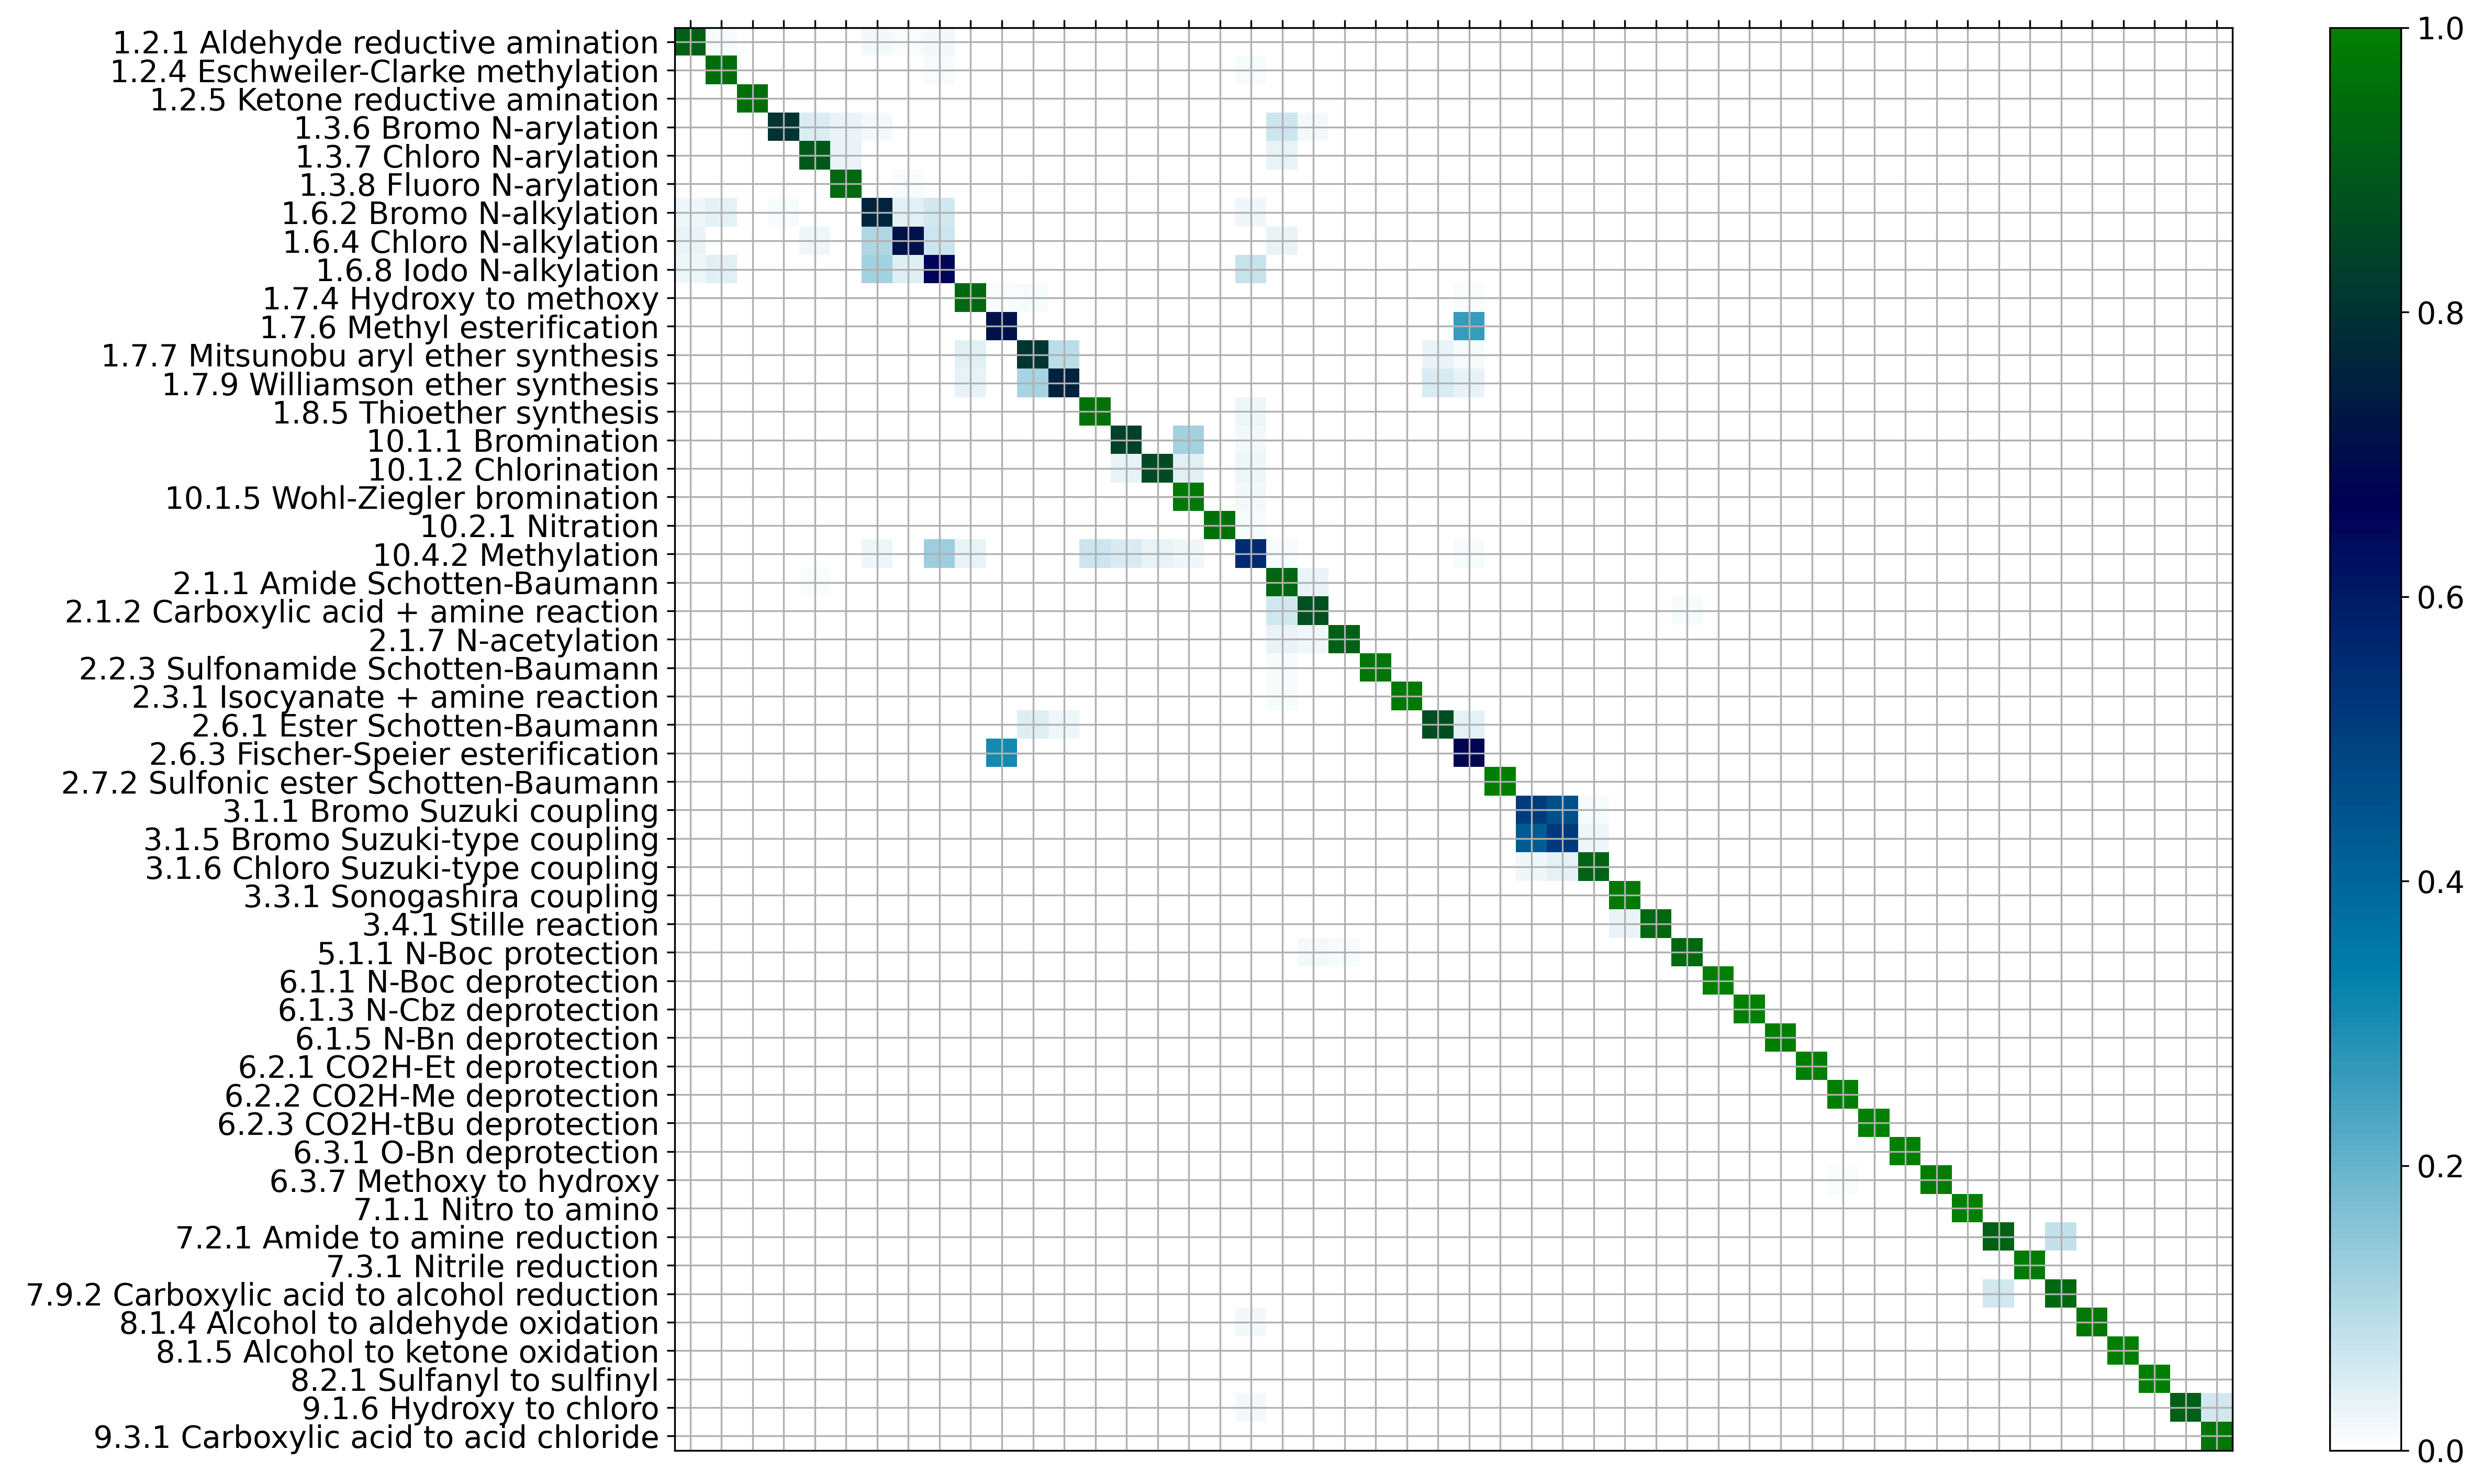

In [8]:
utilsFunctions.labelled_cmat(cmat_KM_fp_AP3,rtypes,figsize=(16,12), labelExtras=names_rTypes, xlabel=False)

Build the K-Means (k=6) clusters for each of the 50 reaction types and store them in a map. Here MG2 FPs were used.

In [9]:
print('training model')
clusters_per_rType_MG2 = {}
for cls in trainFps_fp_MG2:
    cl = KMeans(n_clusters=6)
    res = cl.fit(trainFps_fp_MG2[cls])
    clusters_per_rType_MG2[cls] = res

training model


In [10]:
cmat_KM_fp_MG2 = utilsFunctions.evaluateKMeansClustering(clusters_per_rType_MG2, testFps_fp_MG2, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9487  0.9693  0.9589     1.2.1 Aldehyde reductive amination
 1  0.8638  0.7220  0.7866     1.2.4 Eschweiler-Clarke methylation
 2  0.9300  0.9920  0.9600     1.2.5 Ketone reductive amination
 3  0.8562  0.9133  0.8839     1.3.6 Bromo N-arylation
 4  0.8250  0.8719  0.8478     1.3.7 Chloro N-arylation
 5  0.9200  0.9031  0.9115     1.3.8 Fluoro N-arylation
 6  0.8650  0.8512  0.8580     1.6.2 Bromo N-alkylation
 7  0.8175  0.8237  0.8206     1.6.4 Chloro N-alkylation
 8  0.7400  0.8166  0.7764     1.6.8 Iodo N-alkylation
 9  0.9113  0.9228  0.9170     1.7.4 Hydroxy to methoxy
10  0.7238  0.7292  0.7265     1.7.6 Methyl esterification
11  0.9175  0.9198  0.9186     1.7.7 Mitsunobu aryl ether synthesis
12  0.8600  0.8877  0.8737     1.7.9 Williamson ether synthesis
13  0.9738  0.9582  0.9659     1.8.5 Thioether synthesis
14  0.8875  0.8246  0.8549    10.1.1 Bromination
15  0.8538  0.9192  0.8853    10.1.2 Chlorination
16  0.9062  0.9131

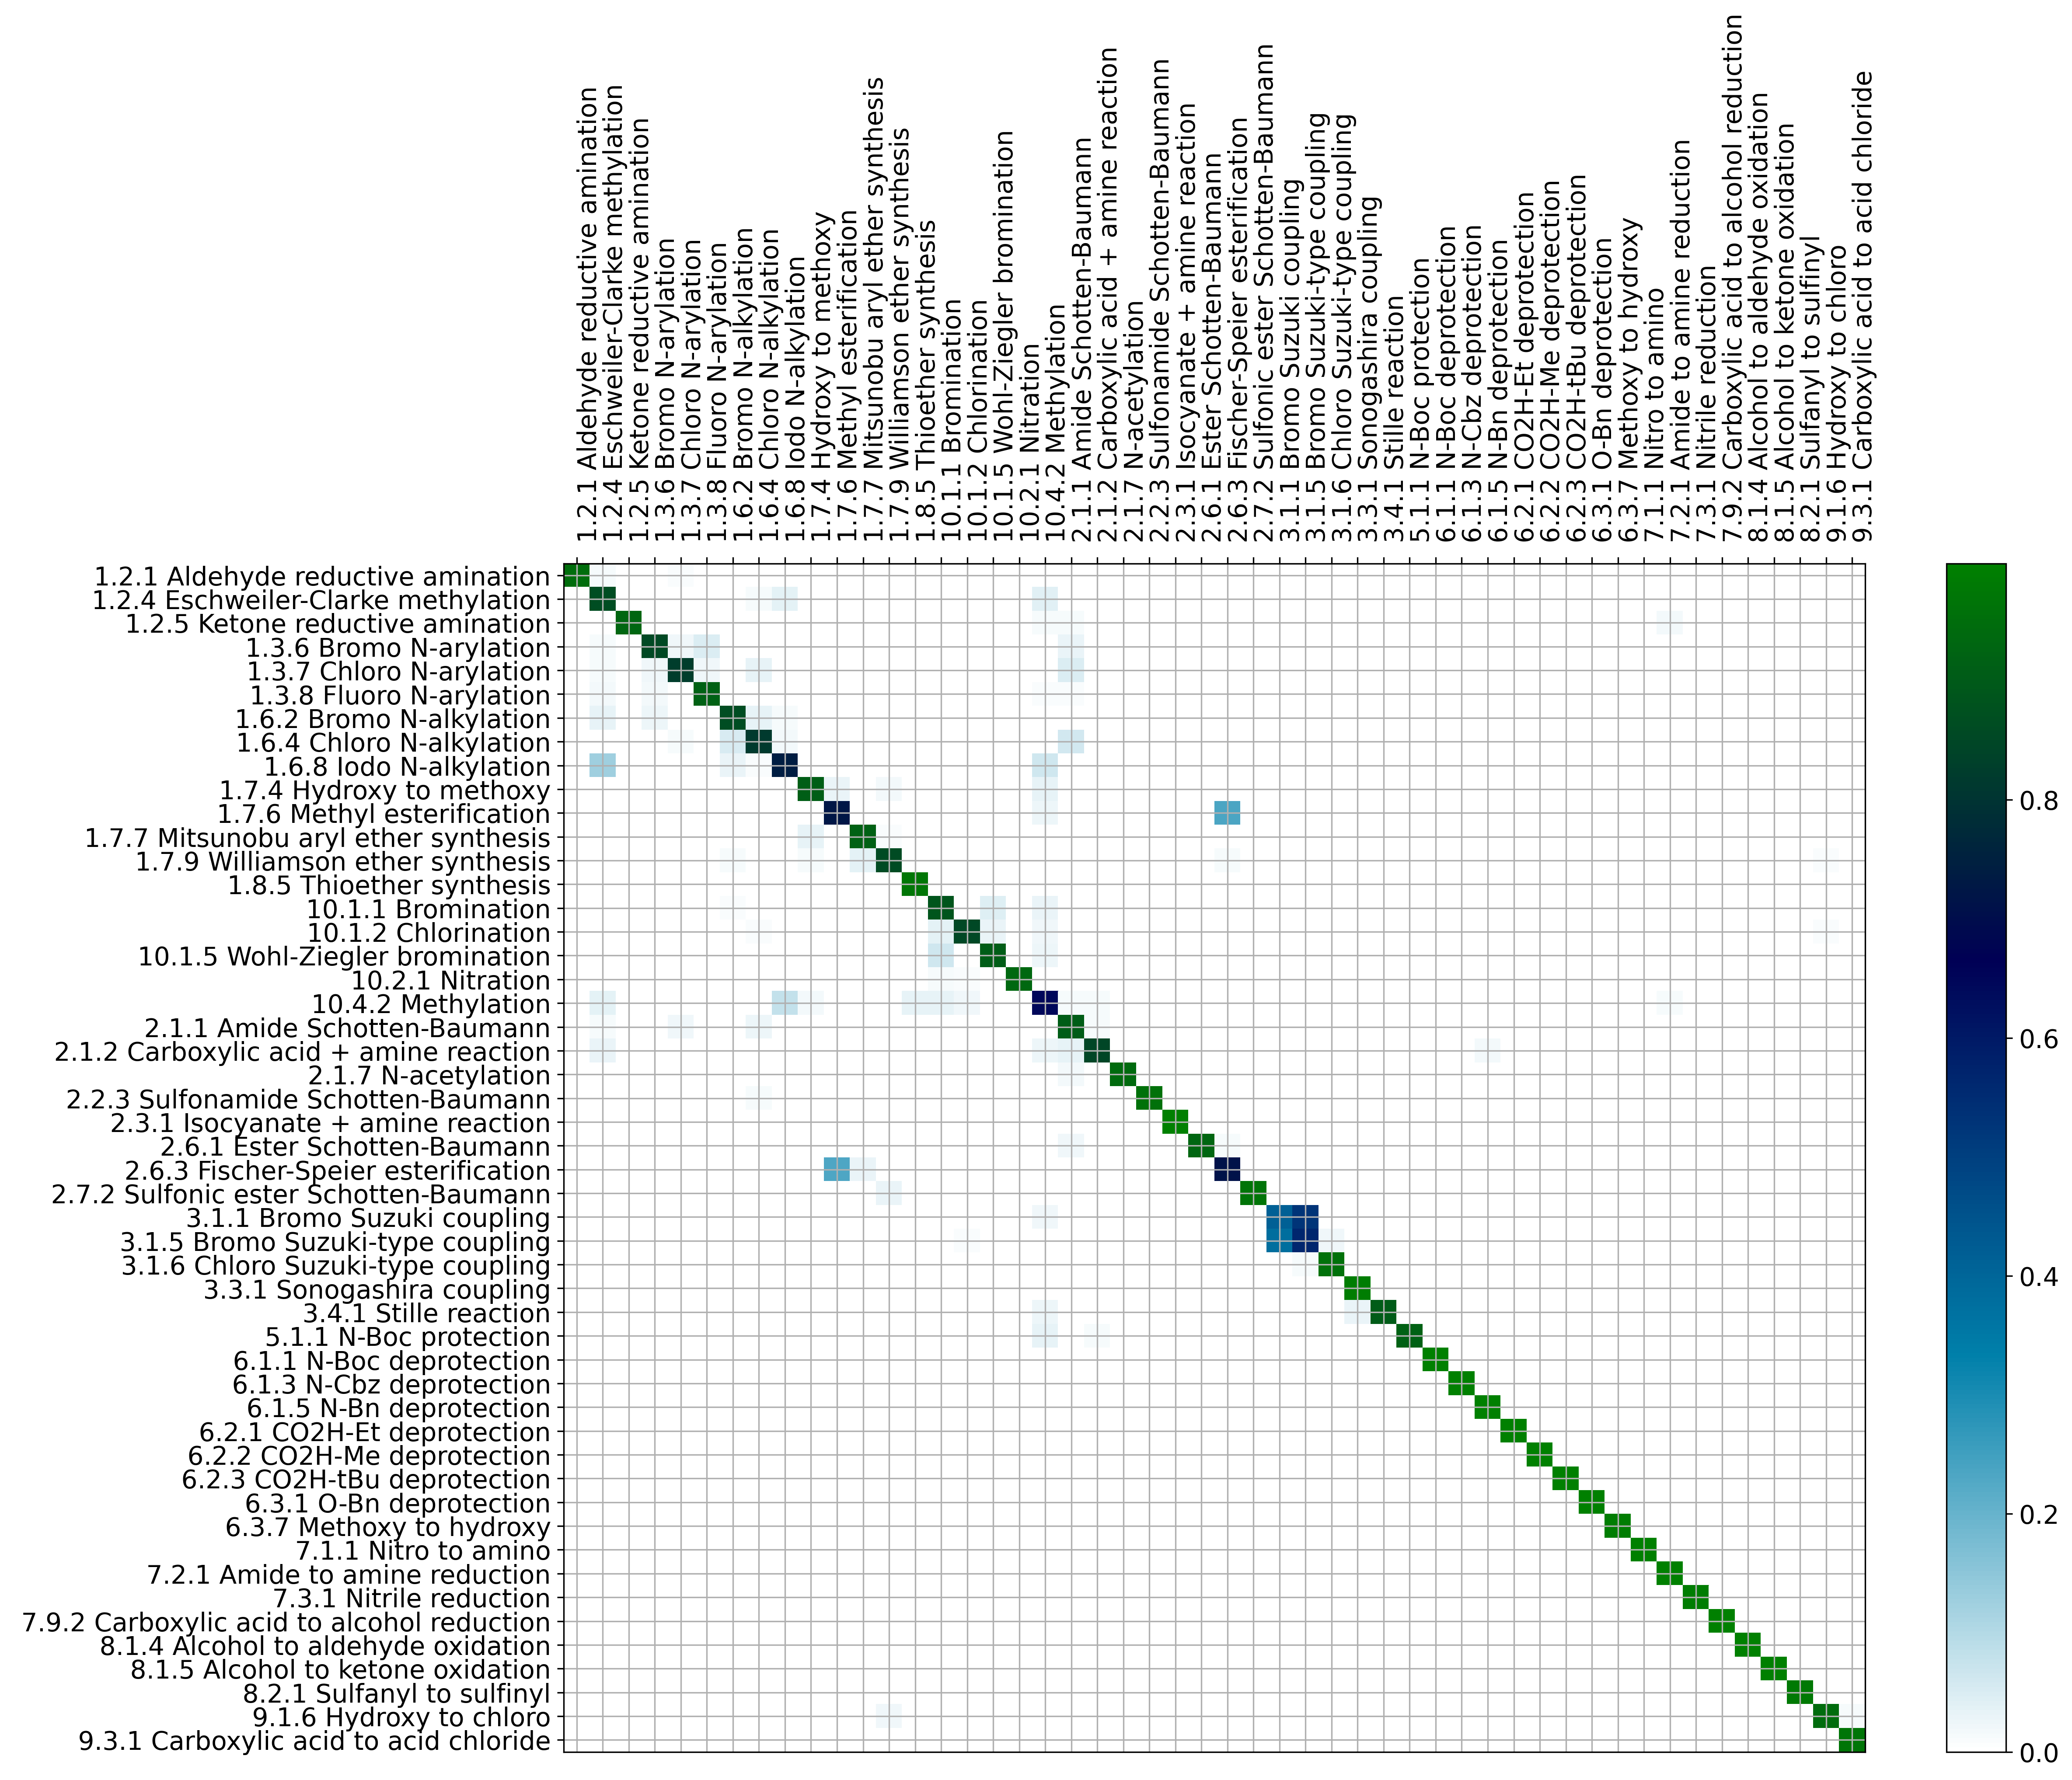

In [11]:
utilsFunctions.labelled_cmat(cmat_KM_fp_MG2,rtypes,figsize=(16,12), labelExtras=names_rTypes)

Build the K-Means (k=6) clusters for each of the 50 reaction types and store them in a map. Here TT FPs were used.

In [12]:
print('training model')
clusters_per_rType_TT = {}
for cls in trainFps_fp_TT:
    cl = KMeans(n_clusters=6)
    res = cl.fit(trainFps_fp_TT[cls])
    clusters_per_rType_TT[cls] = res

training model


In [13]:
cmat_KM_fp_TT = utilsFunctions.evaluateKMeansClustering(clusters_per_rType_TT, testFps_fp_TT, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.8125  0.6410  0.7166     1.2.1 Aldehyde reductive amination
 1  0.8337  0.7014  0.7619     1.2.4 Eschweiler-Clarke methylation
 2  0.8400  0.9372  0.8860     1.2.5 Ketone reductive amination
 3  0.4575  0.7135  0.5575     1.3.6 Bromo N-arylation
 4  0.6787  0.5889  0.6307     1.3.7 Chloro N-arylation
 5  0.7462  0.7407  0.7435     1.3.8 Fluoro N-arylation
 6  0.4150  0.5398  0.4693     1.6.2 Bromo N-alkylation
 7  0.3675  0.5589  0.4434     1.6.4 Chloro N-alkylation
 8  0.5138  0.5517  0.5320     1.6.8 Iodo N-alkylation
 9  0.7975  0.7800  0.7886     1.7.4 Hydroxy to methoxy
10  0.6875  0.5832  0.6311     1.7.6 Methyl esterification
11  0.6012  0.6288  0.6147     1.7.7 Mitsunobu aryl ether synthesis
12  0.5850  0.6852  0.6312     1.7.9 Williamson ether synthesis
13  0.9287  0.9094  0.9190     1.8.5 Thioether synthesis
14  0.6637  0.6722  0.6679    10.1.1 Bromination
15  0.5775  0.7322  0.6457    10.1.2 Chlorination
16  0.9250  0.7789

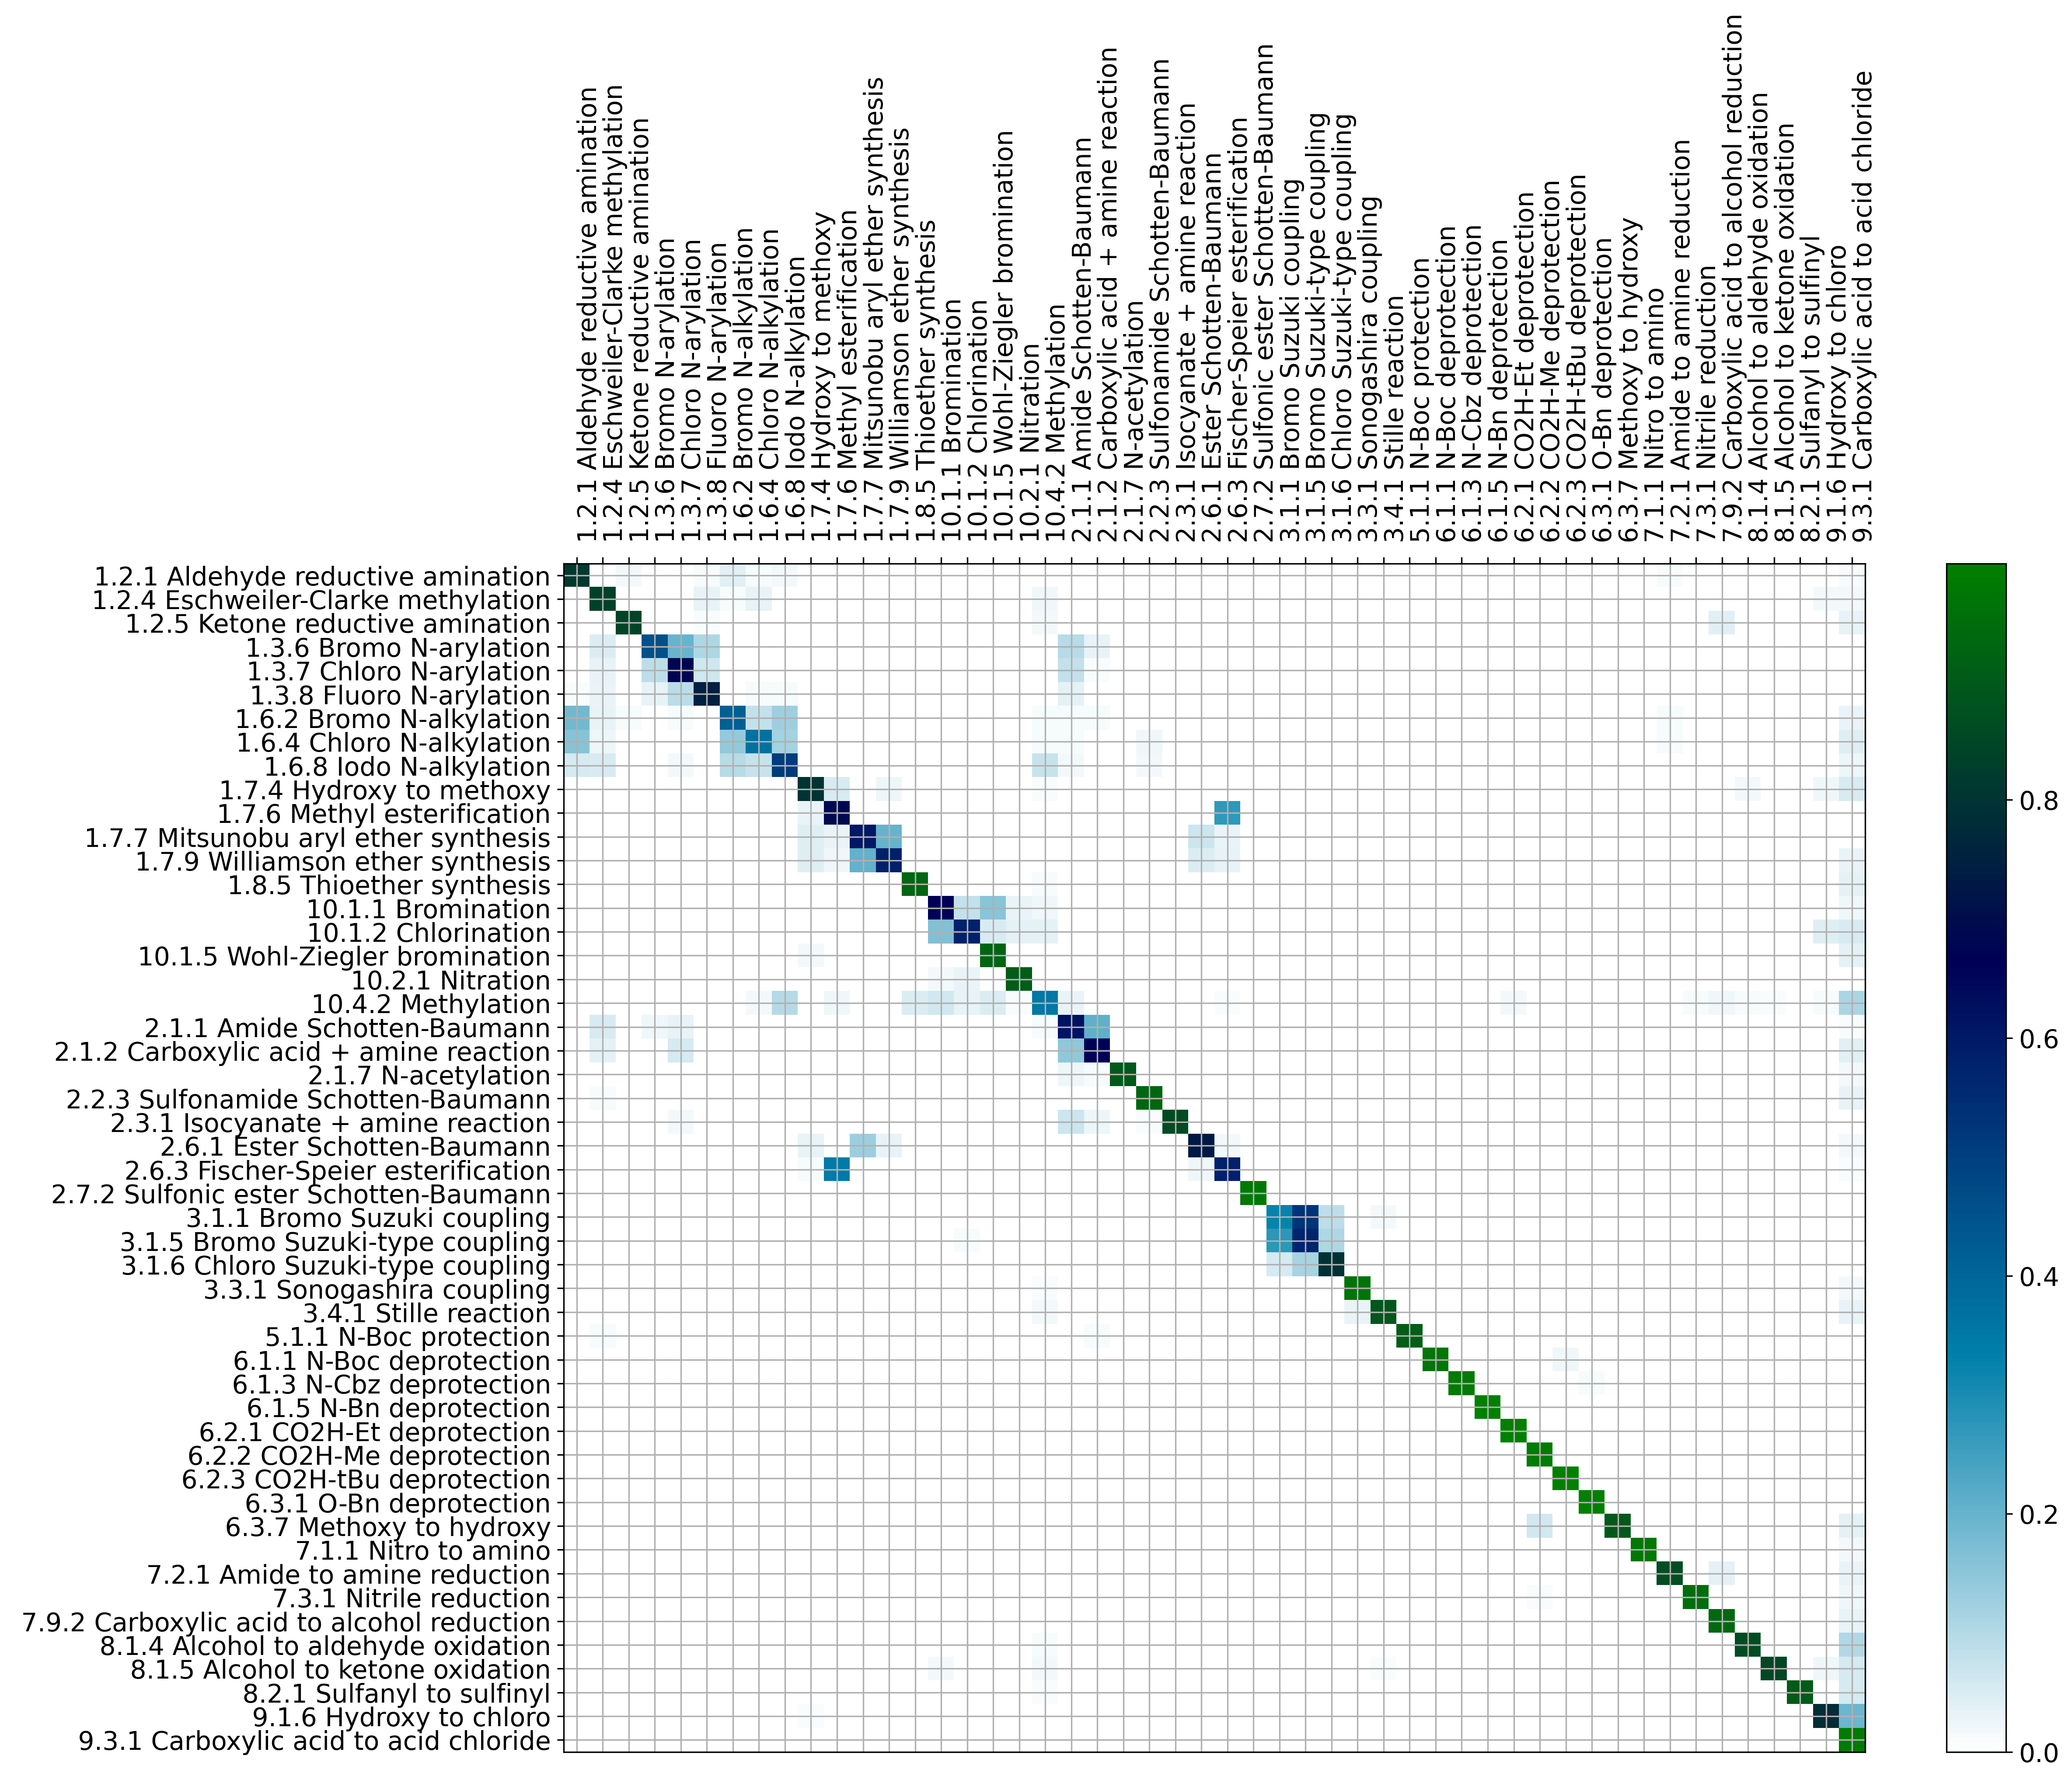

In [14]:
utilsFunctions.labelled_cmat(cmat_KM_fp_TT,rtypes,figsize=(16,12), labelExtras=names_rTypes)